___
# **Starter code for BME 5710 project**
## Instructor -- Rizwan Ahmad (ahmad.46@osu.edu)
## BME5710 -- Spring 2024

___
### Import libraries and sub-libraries.

In [1]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from torchvision.transforms import functional as TF
import tifffile 

___
### Calling a custom code to change the default font for figures to `Computer Modern`. (Optional)

In [2]:
# from fontsetting import font_cmu
# plt = font_cmu(plt)

___
### Check the hardware that is at your disposal

In [3]:
device = torch.device('gpu' if torch.cuda.is_available() else 'cpu')
print('Device available:', device)

Device available: cpu


___
### Read training data from `data/train-clean-tif`


In [4]:
# Loading TIFF images
class TIFFDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.filenames = [f for f in os.listdir(directory) if f.endswith('.tif')]

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.directory, self.filenames[idx])
        image = Image.open(img_path)
        if self.transform: # Dynamically apply data transformation
            image = self.transform(image)
        return image

# Create a transform to convert the images to PyTorch tensors
transform = transforms.Compose([
    transforms.ToTensor()
])

# Create the dataset for training images
train_dataset = TIFFDataset('train-clean-tif', transform=transform)
val_dataset = TIFFDataset('val-clean-tif', transform=transform) # Create the dataset for validation images

# Function to create data loader
def create_loader(train_dataset, batch_size):
    torch.manual_seed(0)  # For reproducibility of random numbers in PyTorch
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # Creates a training DataLoader from this Dataset
    return train_loader

dataset_size = len(train_dataset), len(val_dataset)
print('Number of images in the training dataset:', dataset_size[0])
print('Number of images in the validation dataset:', dataset_size[1])


Number of images in the training dataset: 52
Number of images in the validation dataset: 16


___
### Define a denoising network

#### Here, I have defined a trivial network, which has only one convolutional layer and no activation function. We are essentially doing linear filtering.

In [5]:
class TrivialNet(nn.Module):
    def __init__(self):
        super(TrivialNet, self).__init__()
        self.conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.conv(x)
        return x

___
### Create a function to execute training. Note, we will call this function later.

In [8]:
def train_model(model, opt, criterion, train_loader, test_loader, num_epoch, noise_std, avg_train_losses=[], avg_test_losses=[], epoch=0):

    for epoch in range(epoch, num_epoch): # Loop over the dataset multiple times
        model.train()
        total_train_loss = 0
        for i, y_tr_batch in enumerate(train_loader): # Loop over mini-batches
            x_tr_batch = y_tr_batch.clone()
            # implement data augmentation
            # flip = torch.randint(0,1,(1,)).item()
            # if flip:
            #     x_tr_batch = x_tr_batch.flip(2) # flip the image horizontally
            # rotate = torch.randint(-10, 10,(1,)).item()
            # translate = torch.randint(-10, 10, (2,)).tolist()
            # x_tr_batch = TF.affine(x_tr_batch, angle=rotate, translate=(translate), scale=1, shear=0)
            noise = torch.randn_like(y_tr_batch) * noise_std
            x_tr_batch = x_tr_batch + noise

            # insert translation, rotation, and flipping
            opt.zero_grad() # delete previous gradients
            y_hat_tr_batch = model(x_tr_batch) # forward pass
            loss = criterion(y_hat_tr_batch, y_tr_batch) # compute loss
            loss.backward() # backward pass
            opt.step() # update weights
            total_train_loss += loss.item() # accumulate loss
            # if (i + 1) % 10 == 0:
                # print(f'Epoch {epoch+1}, Iteration {i+1}, Loss: {loss.item():.6f}')

        avg_train_loss = total_train_loss / len(train_loader) # compute average loss
        avg_train_losses.append(avg_train_loss) # accumulate average loss
        
        # Testing
        model.eval()
        with torch.no_grad():
            total_test_loss = 0
            for i, y_te_batch in enumerate(test_loader):
                noise = torch.randn_like(y_te_batch) * noise_std
                x_te_batch = y_te_batch + noise
                y_hat_te_batch = model(x_te_batch)
                loss = criterion(y_hat_te_batch, y_te_batch)
                total_test_loss += loss.item()
            avg_test_loss = total_test_loss / len(test_loader)
            print(f'Epoch {epoch+1}, Test Loss: {avg_test_loss:.6f}, Train Loss: {avg_train_loss:.6f}')
            avg_test_losses.append(avg_test_loss)

        # Save the model and optimizer state
        if (epoch + 1) % 10 == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': opt.state_dict(),
                'avg_train_losses': avg_train_losses[0:epoch],
                'avg_test_losses': avg_test_losses[0:epoch]
            }, 'model_checkpoint.pt')

    print('Length of Training loss', len(avg_test_losses))
    print('Length of Testing loss:', len(avg_test_losses))
    # Plotting
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(range(1, num_epoch+1), avg_train_losses, label='training loss')
    ax.plot(range(1, num_epoch+1), avg_test_losses, label='testing loss')
    ax.plot()
    ax.set_xlabel('epochs')
    ax.set_ylabel('NMSE loss')
    # ax.set_yscale('log')  # Set the vertical axis to log scale
    ax.set_title('training loss')
    ax.legend(['training accuracy', 'test accuracy'])
    ax.grid(True)
    ax.legend()
    plt.show()

___
### Now, let us define hyperparameters and train the network. 

#### Note, in addition to the parameters that controls the network architecture or the training process, you need to select/initialize (i) a data loader, (ii) a model, (iii) an optimizer, and (iv) a loss function.

In [9]:
batch_size = 2  # Number of complete images in each batch
lr = 1e-3  # Learning rate
sig = 0.1  # Noise std
num_epoch = 100  # Epochs

# Create a test loader (using validation for testing)
test_loader = create_loader(val_dataset, batch_size)

In [13]:
# Initilize the model, criterion, and optimizer

# Model, criterion, and optimizer
train_loader = create_loader(train_dataset, batch_size)
model = TrivialNet() # Pick a model
opt = optim.Adam(model.parameters(), lr=lr) # Pick an optimizer
criterion = nn.MSELoss() # Pick a loss function
# criterion = nmse_loss
avg_train_losses = []
avg_test_losses = []
epoch = 0

In [12]:
# Checks to see if there is a checkpoint file, if there is, it will load the model and optimizer state

# load in checkpoint if it exists and train
if os.path.exists('model_checkpoint.pt'):
    checkpoint = torch.load('model_checkpoint.pt')
    model.load_state_dict(checkpoint['model_state_dict'])
    opt.load_state_dict(checkpoint['optimizer_state_dict'])
    avg_train_losses = checkpoint['avg_train_losses']
    avg_test_losses = checkpoint['avg_test_losses']
    epoch = checkpoint['epoch']
    print('Model loaded from checkpoint at epoch', checkpoint['epoch'])
    print('Length of Training loss', len(avg_test_losses))
    print('Length of Testing loss:', len(avg_test_losses))

Model loaded from checkpoint at epoch 99
Length of Training loss 99
Length of Testing loss: 99


Epoch 1, Test Loss: 0.030014, Train Loss: 0.041323
Epoch 2, Test Loss: 0.018006, Train Loss: 0.023268
Epoch 3, Test Loss: 0.013486, Train Loss: 0.015748
Epoch 4, Test Loss: 0.011335, Train Loss: 0.012648
Epoch 5, Test Loss: 0.009682, Train Loss: 0.010762
Epoch 6, Test Loss: 0.008332, Train Loss: 0.009210
Epoch 7, Test Loss: 0.007235, Train Loss: 0.007928
Epoch 8, Test Loss: 0.006367, Train Loss: 0.006912
Epoch 9, Test Loss: 0.005655, Train Loss: 0.006101
Epoch 10, Test Loss: 0.005142, Train Loss: 0.005466
Epoch 11, Test Loss: 0.004735, Train Loss: 0.004978
Epoch 12, Test Loss: 0.004419, Train Loss: 0.004612
Epoch 13, Test Loss: 0.004161, Train Loss: 0.004321
Epoch 14, Test Loss: 0.003980, Train Loss: 0.004101
Epoch 15, Test Loss: 0.003824, Train Loss: 0.003931
Epoch 16, Test Loss: 0.003704, Train Loss: 0.003779
Epoch 17, Test Loss: 0.003576, Train Loss: 0.003665
Epoch 18, Test Loss: 0.003485, Train Loss: 0.003556
Epoch 19, Test Loss: 0.003389, Train Loss: 0.003454
Epoch 20, Test Loss: 

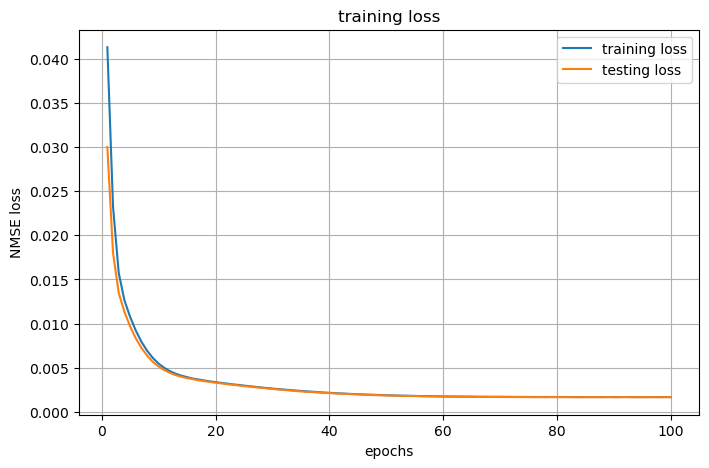

In [14]:
# train model (from scratch or a checkpoint)
train_model(model, opt, criterion, train_loader, test_loader, num_epoch, sig, avg_train_losses, avg_test_losses, epoch)

___
### Apply it to one of the validation image

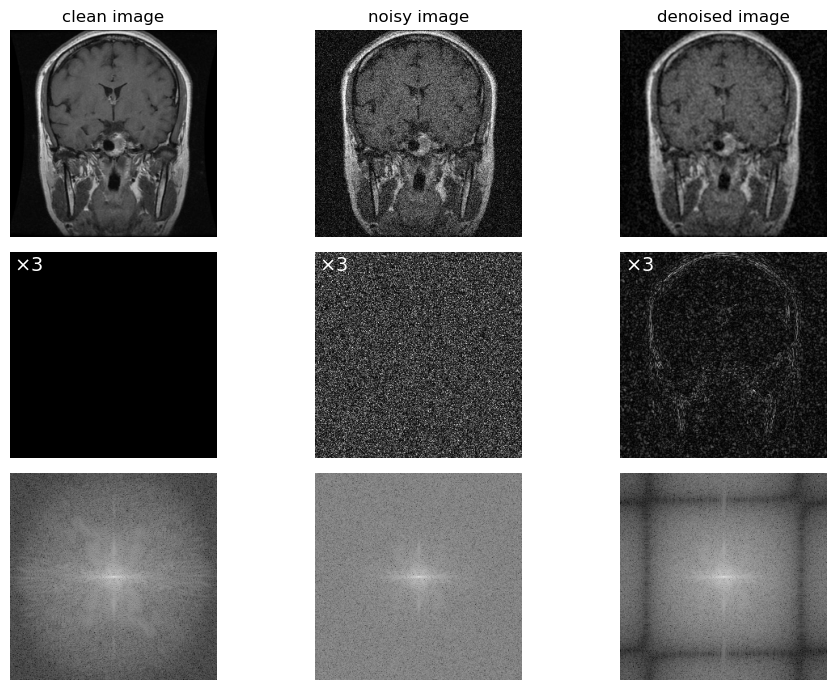

In [48]:
val_dataset = TIFFDataset('val-clean-tif', transform=transform) # Create the dataset for validation images
val_clean = val_dataset[0] # Load one clean image from the validation dataset
val_noisy = val_clean + (torch.randn_like(val_clean) * sig) # Add noise to the clean image
val_denoised = model(val_noisy).detach() # Denoise the noisy image using the trained model
# val_clean_fft = torch.fft.fft2(val_clean)
val_clean_FFT = np.fft.fftn(val_clean)
val_noisy_fft = torch.fft.fftn(val_noisy)
val_denoised_fft = torch.fft.fftn(val_denoised)


# Your existing code to generate the figure and axes
fig, ax = plt.subplots(3, 3, figsize=(10, 7))

# Plot clean image
ax[0, 0].imshow(np.abs(val_clean).squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
ax[0, 0].set_title('clean image')
ax[0, 0].axis('off')

# Plot noisy image
ax[0, 1].imshow(np.abs(val_noisy).squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
ax[0, 1].set_title('noisy image')
ax[0, 1].axis('off')

# Plot denoised image
ax[0, 2].imshow(np.abs(val_denoised).squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
ax[0, 2].set_title('denoised image')
ax[0, 2].axis('off')

# Plot corresponding error images
ax[1, 0].imshow(3*np.abs(val_clean - val_clean).squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
ax[1, 0].axis('off')
ax[1, 0].text(0.02, 0.98, r'$\times 3$', transform=ax[1, 0].transAxes, fontsize=14, va='top', ha='left', color='white')

ax[1, 1].imshow(3*np.abs(val_clean - val_noisy).squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
ax[1, 1].axis('off')
ax[1, 1].text(0.02, 0.98, r'$\times 3$', transform=ax[1, 1].transAxes, fontsize=14, va='top', ha='left', color='white')

ax[1, 2].imshow(3*np.abs(val_clean - val_denoised).squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
ax[1, 2].axis('off')
ax[1, 2].text(0.02, 0.98, r'$\times 3$', transform=ax[1, 2].transAxes, fontsize=14, va='top', ha='left', color='white')

# Plot the Fourier transform of the clean image
ax[2, 0].imshow(np.log(np.abs(np.fft.fftshift(val_clean_FFT.squeeze()))**2), cmap='gray')
ax[2, 0].axis('off')

# Plot the Fourier transform of the noisy image
ax[2, 1].imshow(np.log(np.abs(np.fft.fftshift(val_noisy_fft.squeeze()))**2), cmap='gray')
ax[2, 1].axis('off')

# Plot the Fourier transform of the denoised image
ax[2, 2].imshow(np.log(np.abs(np.fft.fftshift(val_denoised_fft.squeeze()))**2), cmap='gray')
ax[2, 2].axis('off')


plt.tight_layout()
plt.show()


In [44]:
# define NMSE loss
def nmse_loss(output, target):
    diff = output - target
    diff_norm_squared = torch.sum(diff ** 2) ** (1/2)
    target_norm_squared = torch.sum(target ** 2) ** (1/2)
    nmse = diff_norm_squared / (target_norm_squared + 1e-8)  # Add a small constant to avoid division by zero
    return 20 * torch.log10(nmse)  # Convert to dB

# load in validation dataset
val_dataset = TIFFDataset('val-clean-tif', transform=transform) # Create the dataset for validation images

# Create a data loader for the validation dataset
val_loader = create_loader(val_dataset, batch_size)

# Evaluate performance on the validation set using NMSE
criterion = nmse_loss
model.eval()  # Set the model to evaluation mode
total_nmse = 0
with torch.no_grad():  # Disable gradient calculation for efficiency
    for i, val_batch in enumerate(val_loader):
        noisy_batch = val_batch + (torch.randn_like(val_batch) * sig)
        denoised_batch = model(noisy_batch)
        nmse = criterion(denoised_batch, val_batch)
        total_nmse += nmse.item()
nmse = total_nmse / len(val_loader)

print('Validation Normalized Mean Squared Error:', nmse)
print(min(89-5*(nmse + 18.5), 100))

Normalized Mean Squared Error: -15.782929539680481
75.4146476984024
